In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [18]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Data/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [20]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Inspect the class to find the column names and types

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [36]:
# Find the most recent date in the data set.

recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)

2017-08-23


ConversionError: Failed to convert value(s) to axis units: ['2016-08-23', '2016-08-28', '2016-09-02', '2016-09-08', '2016-09-13', '2016-09-19', '2016-09-23', '2016-09-28', '2016-10-03', '2016-10-08', '2016-10-13', '2016-10-19', '2016-10-24', '2016-10-29', '2016-11-03', '2016-11-08', '2016-11-13', '2016-11-18', '2016-11-24', '2016-11-30', '2016-12-05', '2016-12-10', '2016-12-15', '2016-12-21', '2016-12-26', '2016-12-31', '2017-01-05', '2017-01-10', '2017-01-17', '2017-01-22', '2017-01-27', '2017-02-01', '2017-02-07', '2017-02-11', '2017-02-16', '2017-02-22', '2017-02-28', '2017-03-05', '2017-03-10', '2017-03-16', '2017-03-22', '2017-03-27', '2017-04-01', '2017-04-06', '2017-04-12', '2017-04-17', '2017-04-22', '2017-04-28', '2017-05-03', '2017-05-08', '2017-05-14', '2017-05-20', '2017-05-25', '2017-05-31', '2017-06-05', '2017-06-11', '2017-06-16', '2017-06-21', '2017-06-27', '2017-07-02', '2017-07-08', '2017-07-13', '2017-07-18', '2017-07-23', '2017-07-28', '2017-08-03', '2017-08-12', '2017-08-20']

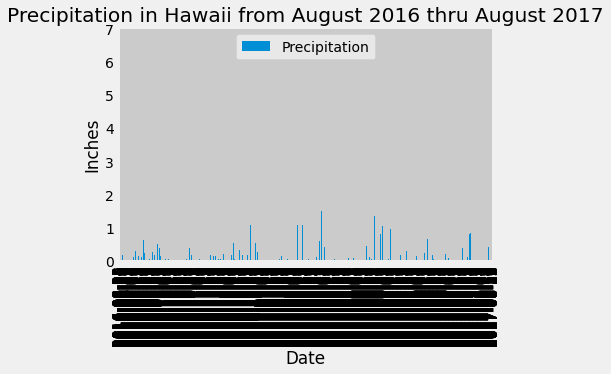

In [99]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores, ordered by date

rain_year = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date <= recent_date).\
        filter(Measurement.date >= query_date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

rain_df = pd.DataFrame(rain_year, columns=['Date', 'Precipitation'])
rain_df.set_index('Date', inplace=True)
rain_fixed = rain_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data

dates = rain_fixed.index.to_list()
ticks = dates[::30]

rain_fixed.plot.bar()
plt.title('Precipitation in HI from Aug 2016 thru Aug 2017')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(ticks)

plt.tight_layout()
plt.show()


In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data

rain_fixed.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [50]:
# Inspect the class to find the column names and types

inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [71]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station.id).count()
print(num_stations)

9


In [66]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
print(most_active)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [76]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs), func.count(Measurement.tobs)).\
                                filter(Measurement.station == 'USC00519281').all()
print(most_active_info)

[(54.0, 85.0, 71.66378066378067, 2772)]


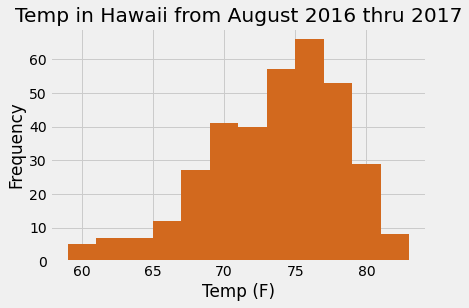

In [97]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_year = session.query(Measurement.tobs).\
        filter(Measurement.date <= recent_date).\
        filter(Measurement.date >= query_date).\
        filter(Measurement.station == 'USC00519281').all()

temp_df = pd.DataFrame(temp_year, columns=['Temp'])
temp_fixed = temp_df.dropna()
temps = temp_fixed['Temp']

plt.hist(temps, bins = 12, color = 'chocolate')

plt.title('Temp in Hawaii from August 2016 thru 2017')
plt.xlabel('Temp (F)')
plt.ylabel('Frequency')

#output_image = f'Output/Temp_HI.png'
#plt.tight_layout()
#plt.savefig(output_image)

plt.show()

# Close session

In [ ]:
# Close Session
session.close()